In [18]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import copy
from IPython import display
from IPython.core.display import display as disp, HTML
#%matplotlib inline
disp(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
# Setup the sensor geometry
# All units in mm

sensor = {
    'px': .1e-3,   #Pixel size
    'npix':[1024, 1024]   #Number of pixels
    }

sensor['fov'] = [sensor['npix'][0]*sensor['px'], sensor['npix'][1]*sensor['px']]


In [20]:
def genz(ii, rhomax):
    # Generates Zernike polynomial function handles
    #
    # Inputs
    # ii : Zernike index
    # rhomax : max lateral coordinate, for normalization
    #
    # outputs:
    # Z : surface height map
    # fx: x gradient
    # fy: y gradient
    # These are handles meant to be evaluated on cartesian coordinates
    
    if ii == 1:
        Z = lambda x, y : np.ones_like(x)
        fx = lambda x, y : 0
        fy = lambda x, y : 0
    elif ii == 2:
        Z = lambda x, y : x/rhomax
        fx = lambda x, y : 1/rhomax
        fy = lambda x, y : 0
    elif ii == 3:
        Z = lambda x, y : y/rhomax
        fx = lambda x, y : 0
        fy = lambda x, y : 1/rhomax    
    elif ii == 4:
        Z = lambda x, y : (x/rhomax)**2 - (y/rhomax)**2
        fx = lambda x, y : 2*x/(rhomax**2)
        fy = lambda x, y : -2*y/(rhomax**2)
    elif ii == 5:
        Z = lambda x, y : -1 + 2*(x/rhomax)**2 + 2*(y/rhomax)**2
        fx = lambda x, y : 4*x/(rhomax**2)
        fy = lambda x, y : 4*y/(rhomax**2)
    elif ii == 6:
        Z = lambda x, y : 2*x*y/(rhomax**2)
        fx = lambda x, y : 2*y/(rhomax**2)
        fy = lambda x, y : 2*x/(rhomax**2)
    elif ii == 7:
        Z = lambda x, y : (x/rhomax)**3 - 3*(x/rhomax)*(y/rhomax)**2
        fx = lambda x, y : 3*x**2/(rhomax**3) - 3*y**2/(rhomax**3)
        fy = lambda x, y : 6*x*y/(rhomax**3)
    elif ii == 8:
        Z = lambda x, y : 3*(x/rhomax)**3 + 3*(x/rhomax)*(y/rhomax)**2 - 2*x/rhomax
        fx = lambda x, y : 9*x**2/(rhomax**3) + 3*y**2/(rhomax**3) - 2/rhomax
        fy = lambda x, y : 6*x*y/(rhomax**3)
    elif ii == 9:
        Z = lambda x, y : 3*(y/rhomax)**3 + 3*(x/rhomax)**2*(y/rhomax) - 2*y/rhomax
        fx = lambda x, y : 6*x*y/(rhomax**3)
        fy = lambda x, y : 9*y**2/(rhomax**3) + 3*x**2/(rhomax**3) - 2/rhomax
    elif ii == 10:
        Z = lambda x, y : -(y/rhomax)**3 + 3*(x/rhomax)**2*y/rhomax
        fx = lambda x, y : 6*x*y/(rhomax**3)
        fy = lambda x, y : -3*y**2/(rhomax**3) + 3*x**2/(rhomax**3)
    return Z, fx, fy

In [21]:
def genW2(zlist, coeffs, rhomax):
    # Creates function handles to generate wavefronts as linear combinations 
    # of zernike polynomials
    #
    # Inputs
    # zlist : list of zernike indices
    # coeffs : corresponding coefficients
    # rhomax : maximum physical coordinate of the pupil, used to normalize
    #
    # Outputs
    # W : Wavefront func handle, can be evaluated at 2D coordinates
    # fx: x gradient handle
    # fy: y gradient handle
    
    zern = []    
    for ii in range(len(zlist)):
        zern.append(genz(zlist[ii],rhomax))

    W = lambda x,y:sum([zern[ii][0](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fx = lambda x,y:sum([zern[ii][1](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fy = lambda x,y:sum([zern[ii][2](x,y)*coeffs[ii] for ii in range(len(zlist))])
    return W, fx, fy

In [22]:
def genSph(efl):
    # Create function handles for spherical wavefront
    # and derivatives, fx and fy.
    # The curvature is designed so that it focuses at a deistance efl
    #
    # Inputs
    # 3fl : effective focal length of the surface (from vertex)
    #
    # Outputs
    # W : Wavefront func handle, can be evaluated at 2D coordinates
    # fx: x gradient handle
    # fy: y gradient handle
    
    Wsph = lambda x,y : efl - efl*np.real(np.sqrt(1 - (x/efl)**2 - (y/efl)**2 + 0j))
    #fx = lambda x,y: x/np.sqrt(1 - (x/efl)**2 - (y/efl)**2)/efl
    #fy = lambda x,y: y/np.sqrt(1 - (x/efl)**2 - (y/efl)**2)/efl
    fx = lambda x,y: x/(efl * np.sqrt(1 - (y/efl)**2 - (x/efl)**2))
    fy = lambda x,y: y/(efl * np.sqrt(1 - (y/efl)**2 - (x/efl)**2))
    return Wsph, fx, fy


In [23]:
# Construct a wavefront as a surface

zlist = np.r_[1:11]    #List of zernikes to use
print(zlist)
error_mag = .001
zco = error_mag*np.random.randn(len(zlist))   #Wavefront error coefficients. If all zeros, perfect focus will be achieved.

# Zero out tilt
zco[0] = 0    
zco[1] = .00
zco[2] = .00
zco[zlist==5] = 0.

# Sinusoidal wavefront constants
wx = 1000    #x frequency
wy = 500    #y frequency
amp = .000001   #Amplitude of oscillaions


[ 1  2  3  4  5  6  7  8  9 10]


In [24]:
# Define the pupil of the system

lam = 550e-6   #Wavelength

pupil = {
    'ca':[.5, .5],   # Clear aperture in x and y
    'efl' : 1,   #Focal lenght, used for spherical component calculation.
    't': 1,    #Distance to sensor
    'ap_type' : 'circ'    #Aperture shape. 'circ' or 'rect'
}

rhomax = pupil['ca'][0]/2

#Generate wavefront functions and add to pupil         
W = genW2(zlist, zco, rhomax)
pupil['W_aber'] = W[0]
pupil['fx_aber'] = W[1]
pupil['fy_aber'] = W[2]

W_sph = genSph(pupil['efl']);
pupil['W_sph'] = W_sph[0]
pupil['fx_sph'] = W_sph[1]
pupil['fy_sph'] = W_sph[2]

In [25]:
pupil['ca']

[0.5, 0.5]

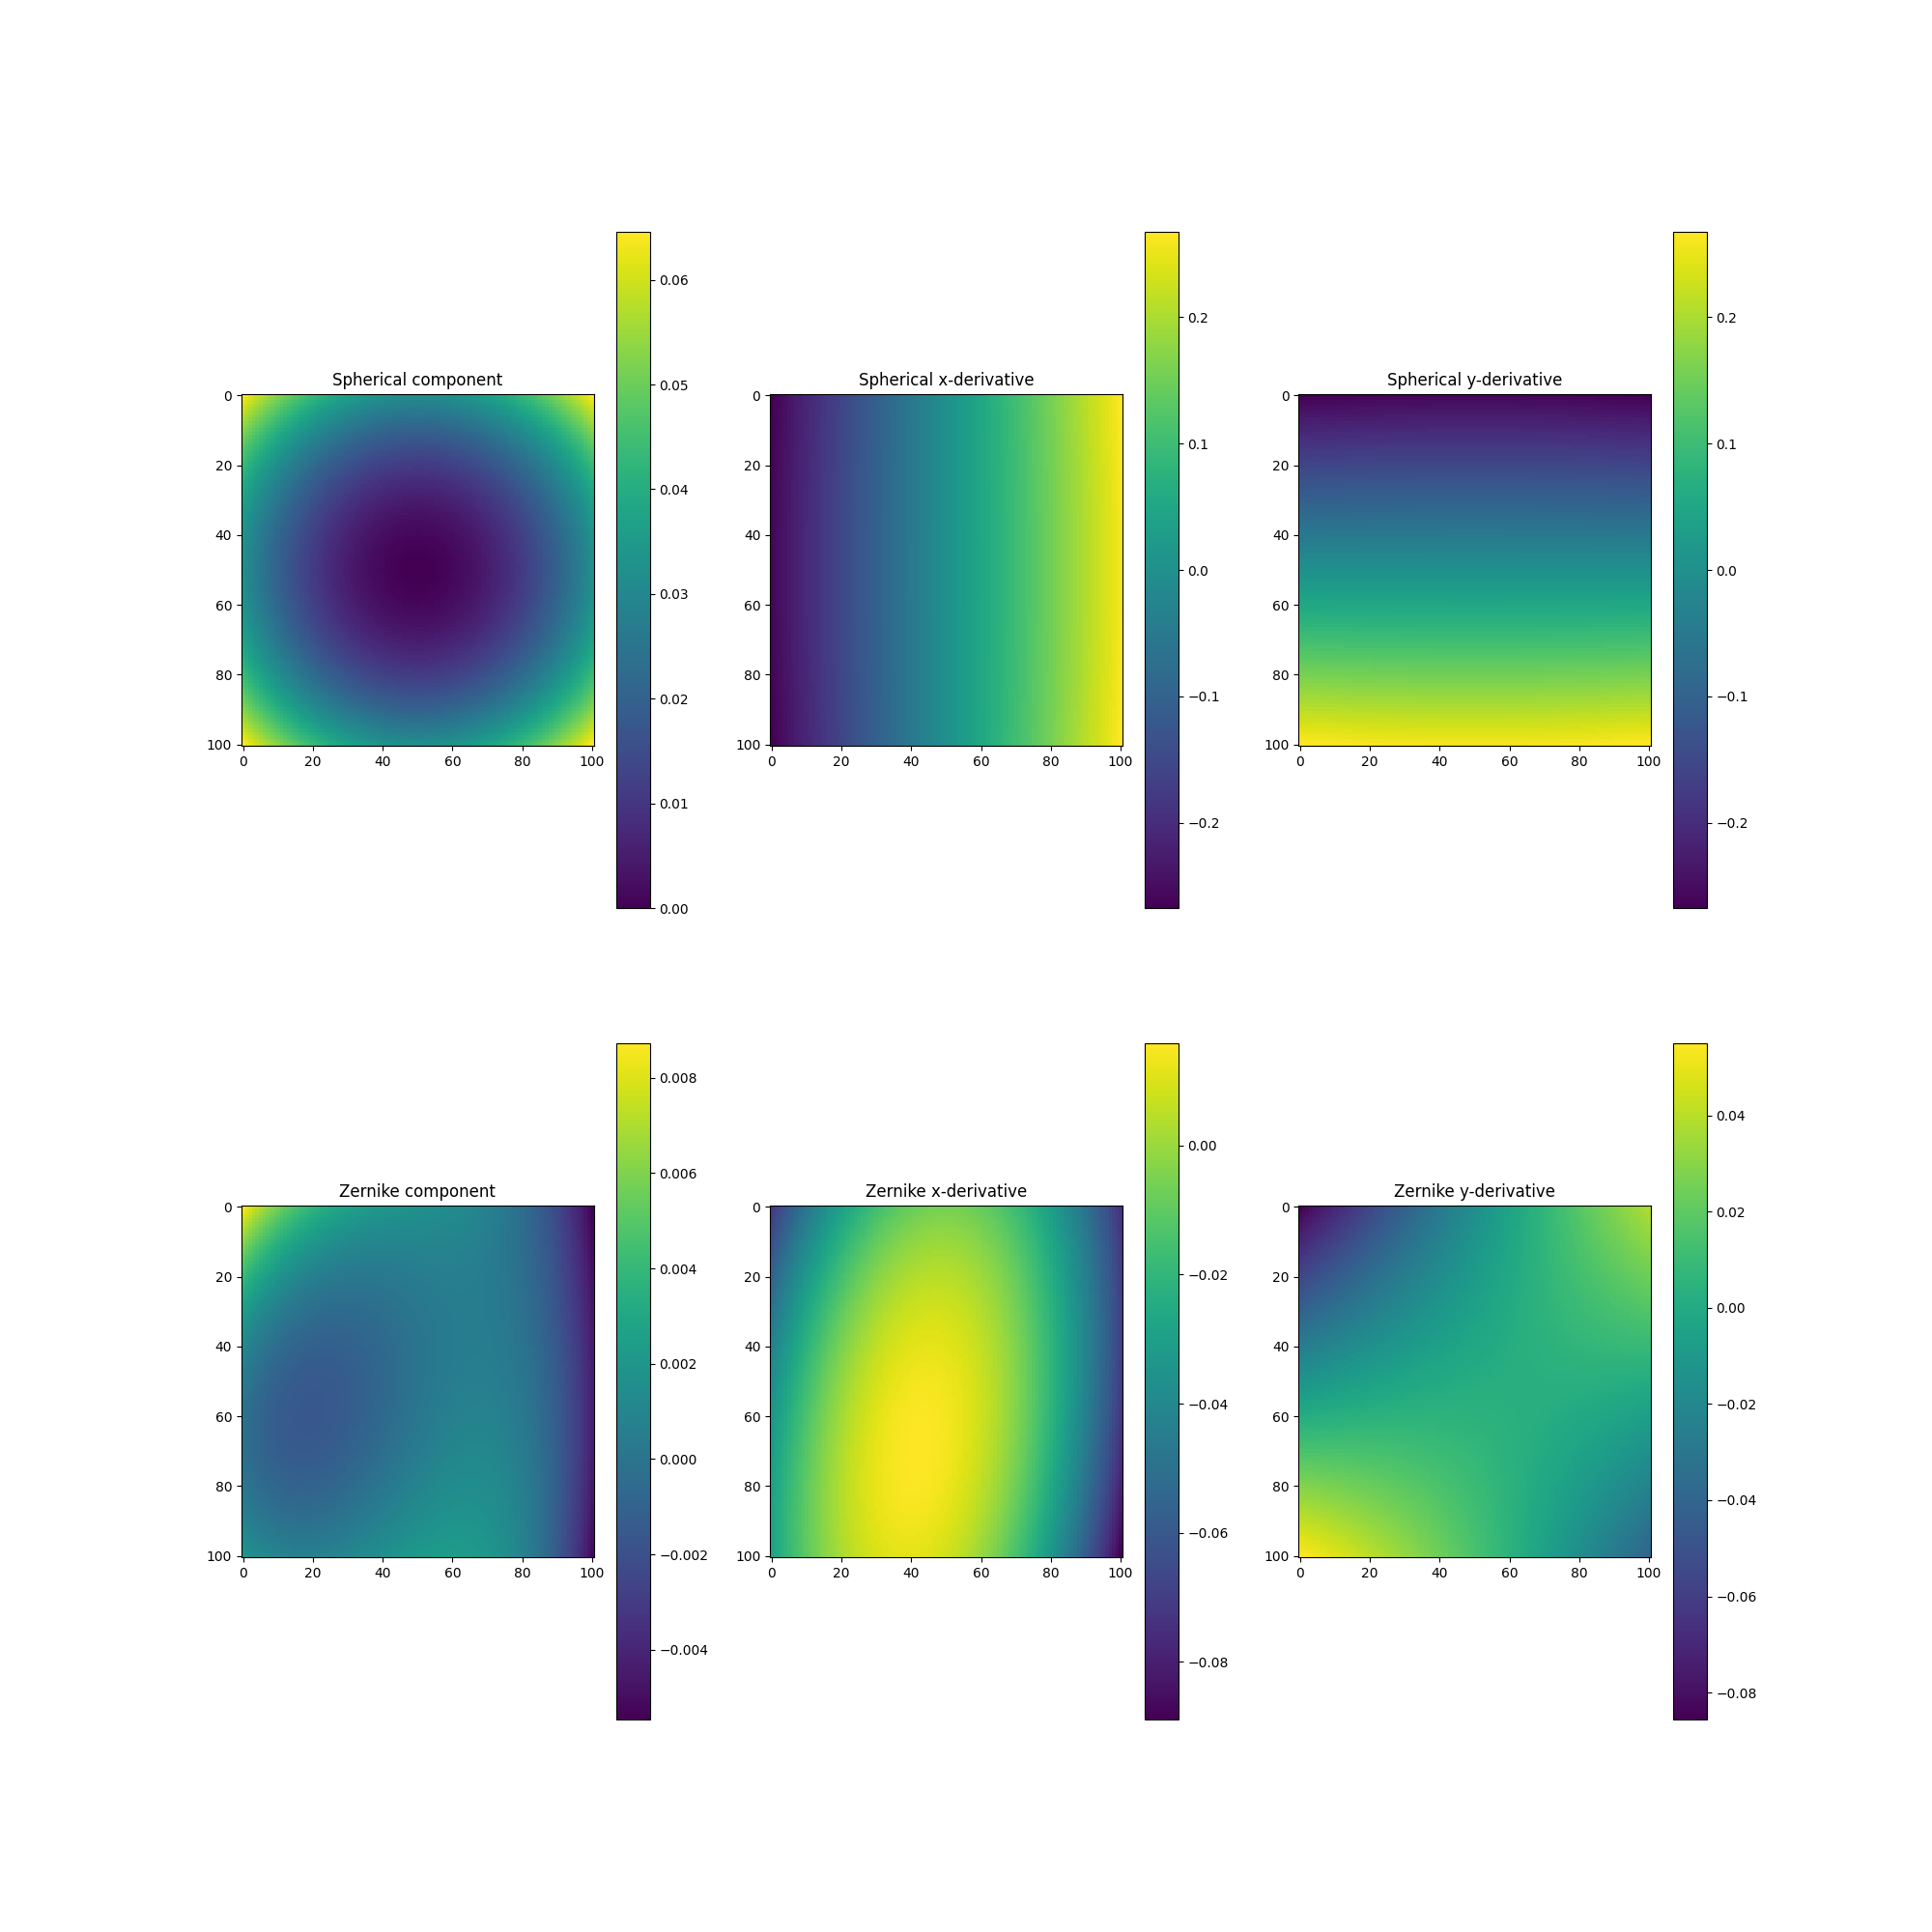

In [26]:
W = genW2(zlist, zco, rhomax)
pupil['W_aber'] = W[0]
pupil['fx_aber'] = W[1]
pupil['fy_aber'] = W[2]

rx = np.linspace(-pupil['ca'][0]/2,pupil['ca'][0]/2,101);
ry = np.linspace(-pupil['ca'][1]/2,pupil['ca'][1]/2,101);

[Rx,Ry] = np.meshgrid(rx,ry)


plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
plt.imshow(pupil['W_sph'](Rx,Ry))
plt.title('Spherical component')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(pupil['fx_sph'](Rx,Ry))
plt.title('Spherical x-derivative')
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(pupil['fy_sph'](Rx,Ry))
plt.title('Spherical y-derivative')
plt.colorbar()


plt.subplot(2,3,4)
plt.imshow(pupil['W_aber'](Rx,Ry))
plt.title('Zernike component')
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(pupil['fx_aber'](Rx,Ry))
plt.title('Zernike x-derivative')
plt.colorbar()

plt.subplot(2,3,6)
plt.imshow(pupil['fy_aber'](Rx,Ry))
plt.title('Zernike y-derivative')
plt.colorbar()

In [27]:
def trace_ray(rhox, rhoy, pupil,debug=False):
    # Function that computes a ray's position and OPD at a flat plane,
    # with the ray originating from an arbitrary wavefront.
    # The ray direction and origin in z will be determined by the sum 
    # of wavefront maps defined in the pupil.
    #
    # Inputs
    # rhox : ray x coordinate
    # rhoy : ray y coordinate
    # pupil : dictionary containing pupil information.
    # debug : print stuff if true
    #
    # Outputs
    # xo and yo : ray output (x,y) coordinates
    # opl : ray path length
    # W : total wavefront (useful for analysis later)
    # fx and fy : ray direction
    # K : x direction cosine
    # L : y direction cosine
    # M : z direction cosine
    
    
    # Generate wavefront and gradients:
    W = pupil['W_sph'](rhox,rhoy) + pupil['W_aber'](rhox,rhoy)
    fx = pupil['fx_sph'](rhox,rhoy) + pupil['fx_aber'](rhox,rhoy)
    fy = pupil['fy_sph'](rhox,rhoy) + pupil['fy_aber'](rhox,rhoy)
    
    # z0 is the total propagton distance
    z0 = W - pupil['t']
    nlength = np.sqrt(1 + fx**2 + fy**2)   #Length of the wavefront normal vector
    
    # x,y, and z direction cosines, respectively
    K = -fx/nlength 
    L = -fy/nlength
    M = 1/nlength
    
    # Total propagation length along ray
    opl = -z0/M

    # Change in x and y ray coordinates
    dx = K*opl
    dy = L*opl
    
    # Output x and y coordinates
    
    yo = rhoy + dy
    xo = rhox + dx;
    
    #debugging stuff. 
    if debug:
        print('(rhox, rhoy):',rhox,rhoy)
        print('(Fx,Fy)',fx,fy)
        print('(dx, dy, dz)=',dx,dy,dz)        
        print('(xo,yo,zo)',xo,yo,z0)
        print('(K,L,M)=',K,L,M)
        print('Delta:', Delta)
        print('\n')

    

    return xo, yo, opl, W, fx, fy, K, L, M

In [28]:
# Rays-only loop
Nrays = 1000
xo = []
yo = []
Wo = []
opl = []
rhox_list = []
rhoy_list = []
for k in range(Nrays):
    
    # Pick a random location on the surface
    if pupil['ap_type'] == 'circ':
        thx = np.random.rand(1)*2*np.pi
        rho = pupil['ca'][0]/2*np.sqrt(np.random.rand(1))
        rhox = rho*np.sin(thx)
        rhoy = rho*np.cos(thx)
    elif pupil['ap_type'] == 'rect':
        rhox = pupil['ca'][1]*(np.random.rand(1) - 0.5)
        rhoy = pupil['ca'][0]*(np.random.rand(1) - 0.5)

    

    # Launch a ray toward the sensor
    rays_out = trace_ray(rhox, rhoy, pupil,debug=False)
    rhox_list.append(rhox)
    rhoy_list.append(rhoy)
    xo.append(rays_out[0])
    yo.append(rays_out[1])
    opl.append(rays_out[2])
    Wo.append(rays_out[3])
    


In [29]:
# Compute RMS spot size
spot_mean_x = np.mean(xo)
spot_mean_y = np.mean(yo)
spot_r_squared = (xo - spot_mean_x)**2 + (yo - spot_mean_y)**2
spotRMS = np.sqrt(np.sum(spot_r_squared/Nrays))
print('RMS spot size = {0} mm'.format(spotRMS))

RMS spot size = 0.02257495814324219 mm


Text(0.5, 0.92, '3D visualization of wavefront and rays')

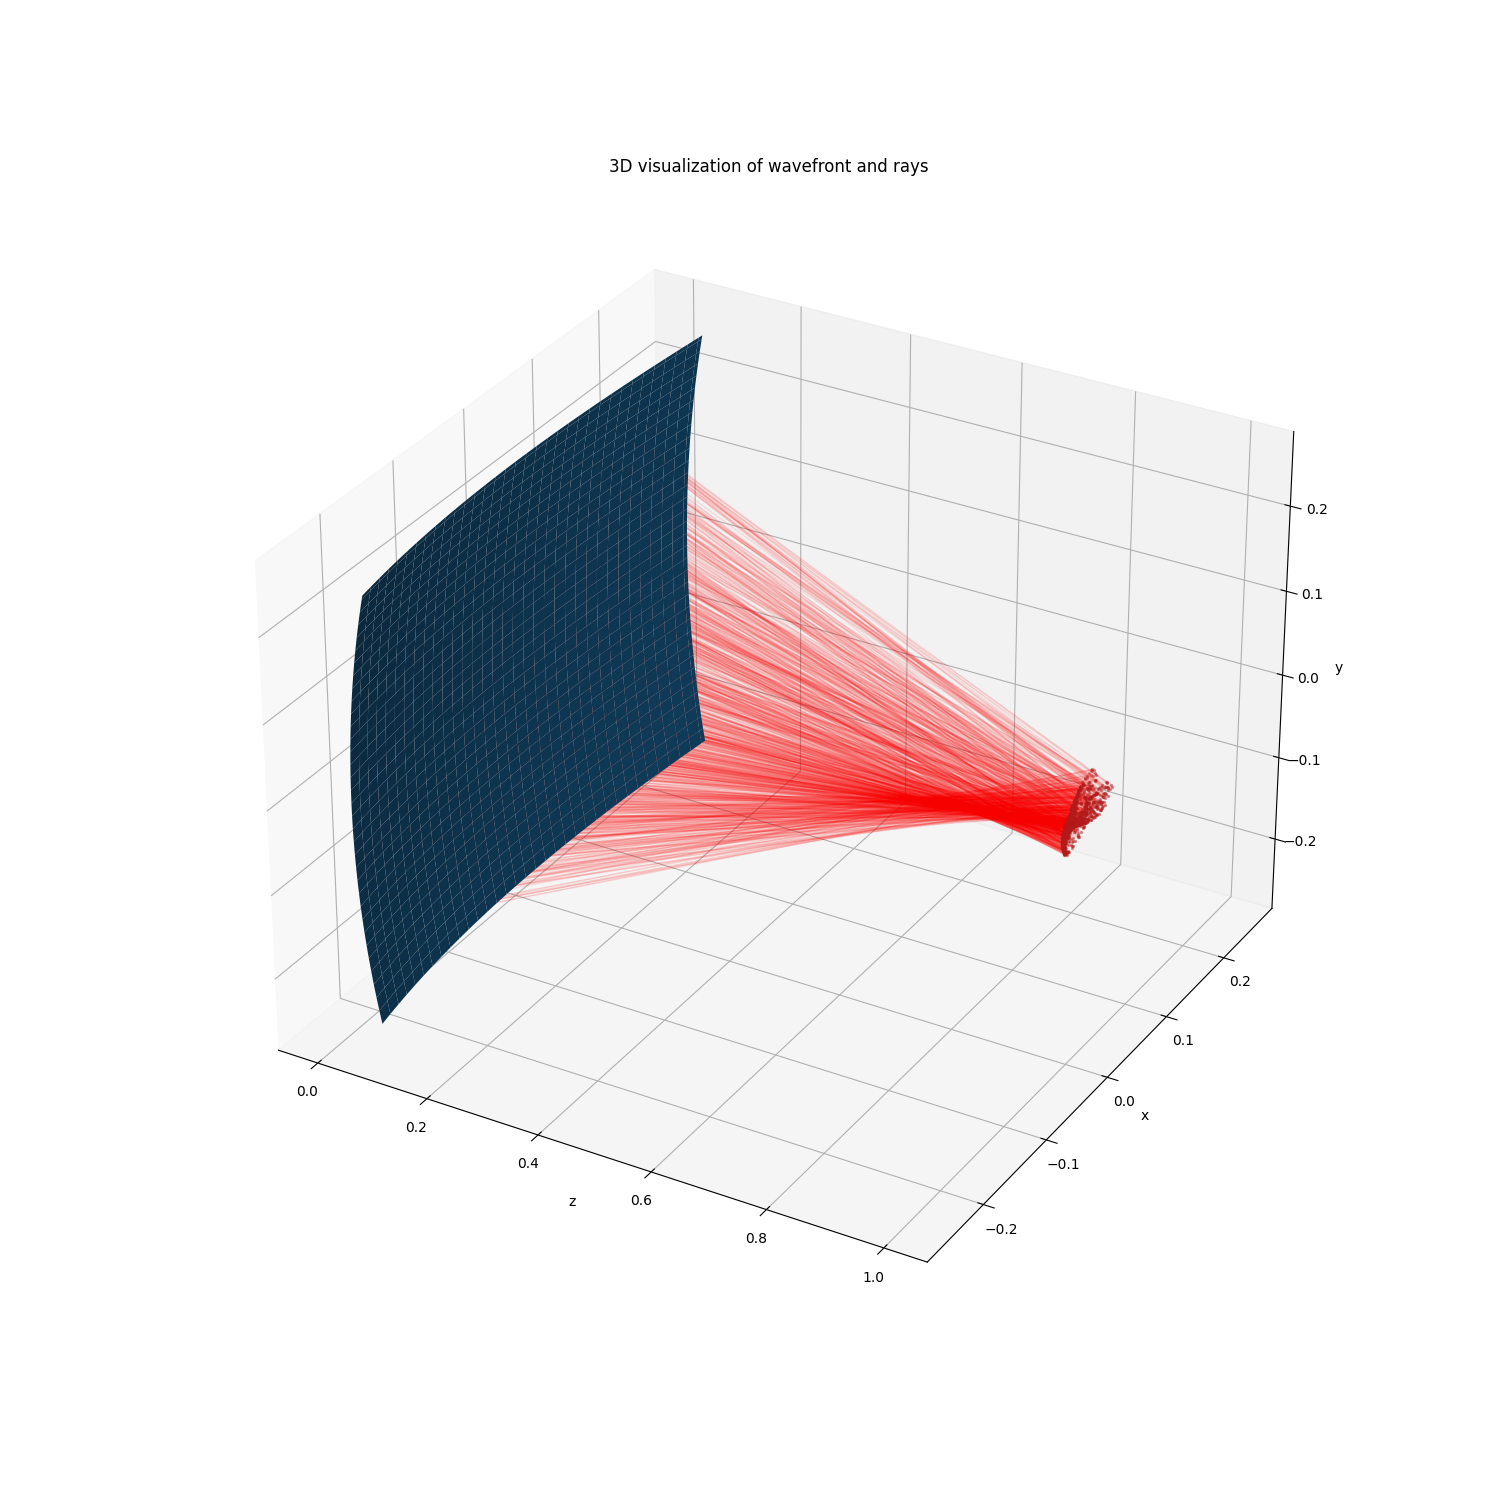

In [30]:
# Plot the wavefront (blue) and rays (red)
#%matplotlib inline

f2 = plt.figure(figsize=(15,15))
ax2 = plt.axes(projection='3d')
W_total = pupil['W_sph'](Rx,Ry) + pupil['W_aber'](Rx,Ry)



for n in range(Nrays):
    ax2.plot([Wo[n][0], pupil['t']], [rhox_list[n][0], xo[n][0]], [rhoy_list[n][0], yo[n][0]],color='r',linewidth=1,alpha=.1)
    ax2.scatter(pupil['t'], xo[n][0], yo[n][0],color=[.7, .1, .1],alpha=.4,s=2)

    
ax2.plot_surface(W_total,Rx,Ry,edgecolor='none',linewidth=0)


plt.xlabel('z')
plt.ylabel('x')
ax2.set_zlabel('y')
ax2.set_title('3D visualization of wavefront and rays')


In [ ]:
# Scatter plot ray output positoins
%matplotlib inline
f = plt.figure(figsize=(13,13))
ax = plt.gca()
ax.set_facecolor((0,0,0))
circ = plt.Circle((spot_mean_x,spot_mean_y),spotRMS,color='r',fill=None)
ax.add_patch(circ)
plt.scatter(xo,yo,s=30,c=[[1, 1, 1]],marker='.',alpha=.9)
plt.scatter(spot_mean_x,spot_mean_y,500,marker='x')
plt.xlabel('x mm')
plt.ylabel('y mm')
ax.set_title('Scatter plot of ray outputs, RMS spot size = {0} mm'.format(spotRMS))
xmn = -np.maximum(np.abs(np.min(xo)),1e-9)
xmx = np.maximum(np.abs(np.max(xo)),1e-9)
ymn = -np.maximum(np.abs(np.min(yo)),1e-9)
ymx = np.maximum(np.abs(np.max(yo)),1e-9)
plt.axis([xmn, xmx, ymn, ymx])
plt.axis('equal')